# 16 Cross Countries URLs - Analysis
In this notebook we analyse the cross-countries retweets containing URLs, to srudy information and misinformation flows across countries.

In [1]:
import pandas as pd
from glob import glob
import numpy as np
import seaborn as sns
from matplotlib.colors import LogNorm, ListedColormap
import matplotlib.pyplot as plt

In [3]:
#data on edges and users are stored in this folder
folder = "/data/public/jlenti/multilang-vax/EuropeAmerica_RTCO"

#list of novax communities
#i transform it into a dataframe with columns (id, country, period, community)
#novax_com = pd.read_csv("/home/jlenti/Files/novax_communities_thres066_0402.csv", index_col = 0).apply(lambda x: pd.Series([x[0]] + x[0].split("_"), index = ["com", "country", "period", "community"]), axis = 1)
novax_com = pd.read_csv("/home/jlenti/Files/novax_communities_9tot_antivax_0902.csv", index_col = 0).apply(lambda x: pd.Series([x[0]] + x[0].split("_"), index = ["com", "country", "period", "community"]), axis = 1)

#list of neutral domains (url shorteners, twitter.com, facebook.com)
neutrals = pd.read_csv("/home/jlenti/Files/neutral_domains_1309.txt")["0"].tolist()
#list of low-credible domains
blacklist = pd.read_csv("/home/jlenti/Files/merged_blacklist_1309.txt")["0"].tolist()
blacklist.extend(pd.read_csv( '/home/jlenti/Files/lemonde_blacklist_2709.txt')["domain"].tolist())
blacklist.extend(pd.read_csv('/home/jlenti/Files/greek_blacklist_1009.txt')["0"].tolist())
#domains associated to youtube
youtube_domains = ["youtube.com", "youtu.be"]

#list of all countries (size ordered)
countries = ["US", "BR", "AR", "GB", "ES", "MX", "FR", "CA", "TR", "VE", "AU", "CO", "IT", "CL", "DE",
             "PT", "IE", "PY", "EC", "RU", "UY", "NZ", "PL", "NL", "PE", "CU", "PA", "GR"]
#sorted by language
lang_sort = ["US", "IE", "GB", "CA", "NZ", "AU", "FR", "IT", "PL", "NL", "DE", "RU", "TR", 
             "BR", "PT", "GR", "AR", "ES", "MX","VE", "CO", "CL",
             "PY", "EC", "UY", "PE", "CU", "PA"]
#countries speaking english or italian, the ones with a list of low-credible domains
LC_countries = ["IT", "US", "GB", "AU", "NZ", "IE"]
#countries with a novax community, sorted by language
lang_sort_novax = ["US", "GB", "IE", "AU", "NZ", "CA", "DE", "FR", "GR", "IT",
                   "NL", "PL", "RU",  "BR", "PA", "CU", "ES", "UY"]
#named periods
periods = ["period" + str(u + 1) for u in range(4)]
periods_names = ["pre-COVID", "pre-vax", "vax development", "vax rollout"]
periods_abbr = ["PC", "PV", "VD", "VR"]


#folder to save the plots
plots_folder =  "/home/jlenti/plots/NoVax_Communities"

filtered_users = pd.concat([pd.read_csv("/data/public/jlenti/multilang-vax/Geolocation_Mismatches/more_countries_users_RT.csv"),
                            pd.read_csv("/data/public/jlenti/multilang-vax/Geolocation_Mismatches/misgeo_popular_user_countries_pairs.csv")])["user"].tolist()

In [4]:
cross_urls_df = pd.read_csv("/home/jlenti/Files/cross_border_retweeted_urls_2403.csv", index_col = 0)

### Absolute number of LC domains retweeted from one country to another
For each pair of country, count the number of LC domains retweeted by user in one to user in the other

In [40]:
#for each pair of countries I count the low-credible URLs retweeted

period = "period1"

#count the LC and non-LC URL retweeted per pair of countries
df = cross_urls_df.query("(period == @period)&(LC)") \
.groupby(["user_country_code", "RT_user_country_code"]).count()["urls"] \
.reset_index() \
.rename(columns = {"user_country_code": "source", "RT_user_country_code": "target", "urls": "weight"}) \
.set_index(["source", "target"]) \
.unstack().fillna(0)["weight"]
df

target,AU,CA,DE,ES,FR,GB,IE,IT,NL,NZ,PL,PT,RU,US
source,,,,,,,,,,,,,,
AR,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
AU,0.0,9.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,277.0
BR,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
CA,1.0,0.0,0.0,0.0,0.0,3.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,350.0
CL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
CO,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
DE,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,78.0
EC,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
ES,0.0,4.0,0.0,0.0,1.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,19.0


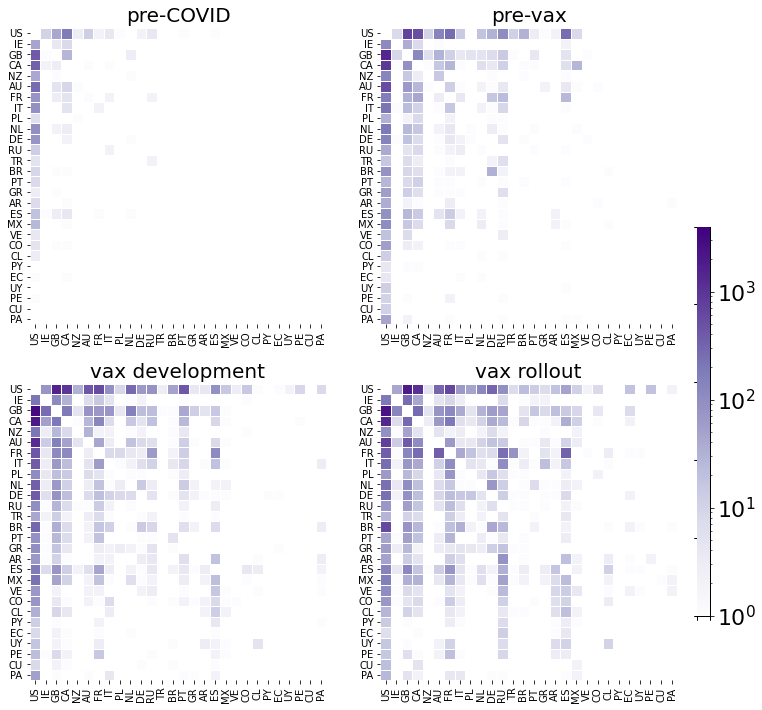

In [43]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 12))#,     

fig.subplots_adjust(wspace = 0.1, hspace = 0.2)

abc_fsize = 26
supylab_fsize = 28
supxlab_fsize = 28
ylab_fsize = 24
xlab_fsize = 24
ticks_fsize = 14
cbar_fsize = 22
tit_fsize = 20

for ax, period, pname in zip(axes.ravel(), periods, periods_names):
    df = cross_urls_df.query("(period == @period)&(LC)") \
    .groupby(["user_country_code", "RT_user_country_code"]).count()["urls"] \
    .reset_index() \
    .rename(columns = {"user_country_code": "source", "RT_user_country_code": "target", "urls": "weight"}) \
    .set_index(["source", "target"]) \
    .unstack().fillna(0)["weight"]
    for c in countries:
        if c not in df.columns:
            df[c] = 0
        if c not in df.index:
            df.loc[c] = 0

    cbar_ax = fig.add_axes([.91, .20, .015, .45])
    cbar_ax.yaxis.set_ticklabels([])
    cbar_ax.xaxis.set_ticklabels([])
    
    cbar_ax.tick_params(labelsize = cbar_fsize) 

    for c in lang_sort:
        if c not in df.columns:
            df[c] = np.nan
            df.loc[c] = np.nan
            
    df = df.loc[lang_sort, lang_sort]

    sns.heatmap(df, square = True,
                norm = LogNorm(vmin = 10**(0), vmax = 10**(3.6)), cmap = "Purples", ax = ax,
                linewidth = .5, cbar = period == "period4", cbar_ax = cbar_ax)
    
    sns.heatmap(df.loc[lang_sort, lang_sort], 
                mask = df == df, square = True,
                linewidths = 0.5,
                cmap = ListedColormap(["lightgrey"]), 
                cbar = False, ax = ax)

    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(pname, fontsize = tit_fsize)



### Proportion of LC from one country to another
Among the URLs country $i$ import from country $j$, what proportion come from LC domains?

This tell us how credible are the contents going from one country to another

In [12]:
#for each pair of countries I can measure the proportion of low-credible domains among the URLs retweeted

period = "period1"

#count the LC and non-LC URL retweeted per pair of countries
df = cross_urls_df.query("period == @period") \
.groupby(["user_country_code", "RT_user_country_code", "LC"]).count()["urls"] \
.reset_index()
#unstack to have a column LC and a columns non-LC
df = df.rename(columns = {"user_country_code": "source", "RT_user_country_code": "target", "urls": "weight"}) \
.set_index(["source", "target", "LC"]) \
.unstack().fillna(0)["weight"]
#count the proportion of LC per row  (es. [IT, US, 30, 70, 0.3])
df = df.assign(LC_prop = lambda x: x[True] / x.sum(axis = 1)) 
#unstack to create a matrix with countries as columns and rows, and keep only the proportion of LC
df = df.unstack()["LC_prop"]
df

target,AR,AU,BR,CA,CL,CO,CU,DE,EC,ES,...,PA,PE,PL,PT,PY,RU,TR,US,UY,VE
source,,,,,,,,,,,,,,,,,,,,,
AR,NaN,0.000000,0.0,0.083333,0.0,0.0,0.0,0.000000,NaN,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.025926,0.0,0.0
AU,0.0,NaN,0.0,0.064748,NaN,0.0,0.0,0.000000,NaN,0.000000,...,0.0,NaN,NaN,0.000000,NaN,0.000000,0.0,0.141471,NaN,NaN
BR,0.0,0.000000,NaN,0.090909,0.0,0.0,0.0,0.000000,NaN,0.000000,...,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,0.018908,NaN,0.0
CA,0.0,0.009434,0.0,NaN,0.0,0.0,NaN,0.000000,NaN,0.000000,...,NaN,NaN,0.000000,NaN,NaN,0.000000,0.0,0.108359,NaN,0.0
CL,0.0,0.000000,0.0,0.000000,NaN,NaN,NaN,0.000000,NaN,0.000000,...,NaN,NaN,NaN,NaN,0.0,0.000000,0.0,0.034884,NaN,0.0
CO,0.0,0.000000,0.0,0.076923,0.0,NaN,NaN,0.000000,0.0,0.000000,...,0.0,NaN,NaN,NaN,NaN,0.000000,NaN,0.030120,NaN,0.0
CU,0.0,NaN,0.0,NaN,0.0,NaN,NaN,0.000000,NaN,0.000000,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.0
DE,0.0,0.000000,0.0,0.023810,NaN,0.0,NaN,NaN,NaN,0.000000,...,NaN,0.0,0.000000,0.000000,NaN,0.000000,0.0,0.096415,NaN,0.0
EC,0.0,NaN,0.0,0.250000,0.0,0.0,0.0,0.000000,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.015385,0.0,0.0


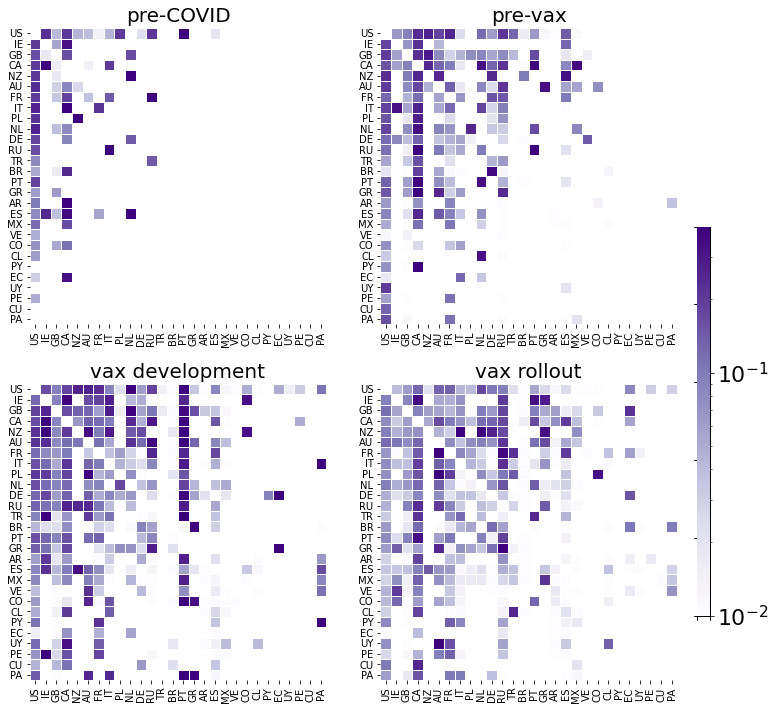

In [32]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 12))#,     

fig.subplots_adjust(wspace = 0.1, hspace = 0.2)

abc_fsize = 26
supylab_fsize = 28
supxlab_fsize = 28
ylab_fsize = 24
xlab_fsize = 24
ticks_fsize = 14
cbar_fsize = 22
tit_fsize = 20

for ax, period, pname in zip(axes.ravel(), periods, periods_names):
    df = cross_urls_df.query("(period == @period)&(~neutral)") \
    .groupby(["user_country_code", "RT_user_country_code", "LC"]).count()["urls"] \
    .reset_index() \
    .rename(columns = {"user_country_code": "source", "RT_user_country_code": "target", "urls": "weight"}) \
    .set_index(["source", "target", "LC"]) \
    .unstack().fillna(0)["weight"] \
    .assign(LC_prop = lambda x: x[True] / x.sum(axis = 1)).unstack()["LC_prop"]
    
    cbar_ax = fig.add_axes([.91, .20, .015, .45])
    cbar_ax.yaxis.set_ticklabels([])
    cbar_ax.xaxis.set_ticklabels([])
    
    cbar_ax.tick_params(labelsize = cbar_fsize) 

    for c in lang_sort:
        if c not in df.columns:
            df[c] = np.nan
            df.loc[c] = np.nan
            
    df = df.loc[lang_sort, lang_sort]

    sns.heatmap(df, square = True,
                norm = LogNorm(vmin = 10**(-2), vmax = 10**(-0.4)), cmap = "Purples", ax = ax,
                linewidth = .5, cbar = period == "period4", cbar_ax = cbar_ax)
    
    sns.heatmap(df.loc[lang_sort, lang_sort], 
                mask = df == df, square = True,
                linewidths = 0.5,
                cmap = ListedColormap(["lightgrey"]), 
                cbar = False, ax = ax)

    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(pname, fontsize = tit_fsize)



### Proportion of LC domains that come from one country
This is another important measure.

Among the LC domains that country $i$ import from the other countries, what proportion come from country $j$?
This tell us the influence that has a certain country in the spread of misinformation to another.

In [33]:
#count LC domains retweeted from one country to another
df = cross_urls_df.query("(period == @period)&(LC)") \
.rename(columns = {"user_country_code": "country", "RT_user_country_code": "RT_country"}) \
.groupby(["country", "RT_country"]).count()
#unstack to have the adjcency matrix of the LC domains retweeted
df = df.unstack()["urls"].fillna(0)
#normalize the rows, to have the proportion of LC domains imported per country
df = df.apply(lambda x: x / x.sum(), axis = 1)
df

RT_country,AR,AU,BR,CA,CL,CO,CU,DE,EC,ES,...,NZ,PA,PE,PL,PT,RU,TR,US,UY,VE
country,,,,,,,,,,,,,,,,,,,,,
AR,0.000000,0.000000,0.005025,0.025126,0.015075,0.000000,0.000000,0.000000,0.005025,0.100503,...,0.000000,0.000000,0.010050,0.000000,0.000000,0.422111,0.000000,0.251256,0.000000,0.000000
AU,0.000706,0.000000,0.000706,0.072689,0.000000,0.000000,0.000000,0.012703,0.000000,0.007057,...,0.000000,0.000000,0.000000,0.002823,0.000706,0.009880,0.000000,0.532816,0.000000,0.000000
BR,0.000000,0.001174,0.000000,0.031690,0.001174,0.000000,0.000000,0.049296,0.002347,0.002347,...,0.000000,0.001174,0.000000,0.002347,0.002347,0.029343,0.000000,0.719484,0.001174,0.000000
CA,0.000948,0.031280,0.004265,0.000000,0.000000,0.000474,0.000000,0.018957,0.000948,0.017062,...,0.001422,0.000000,0.000000,0.001896,0.000474,0.011374,0.000474,0.666825,0.000000,0.000000
CL,0.072289,0.000000,0.012048,0.060241,0.000000,0.000000,0.000000,0.000000,0.000000,0.240964,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.048193,0.012048,0.337349,0.000000,0.000000
CO,0.045113,0.007519,0.000000,0.060150,0.022556,0.000000,0.000000,0.000000,0.000000,0.075188,...,0.000000,0.000000,0.000000,0.000000,0.007519,0.082707,0.000000,0.533835,0.000000,0.000000
CU,0.000000,0.000000,0.000000,0.178571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.750000,0.000000,0.000000
DE,0.002222,0.020000,0.002222,0.046667,0.000000,0.000000,0.000000,0.000000,0.004444,0.017778,...,0.000000,0.000000,0.000000,0.035556,0.000000,0.026667,0.002222,0.540000,0.000000,0.000000
EC,0.041667,0.000000,0.000000,0.041667,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.250000,0.000000,0.000000


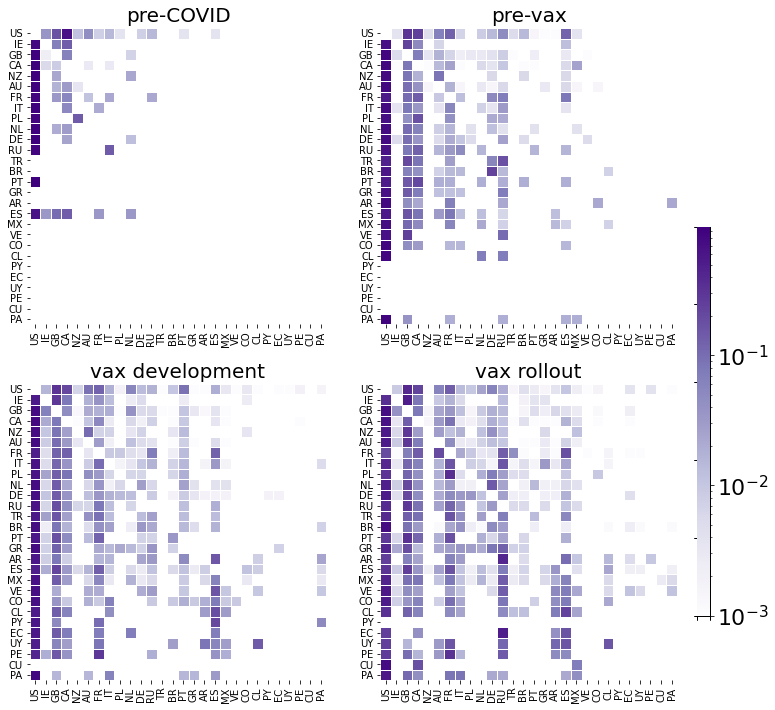

In [37]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 12))#,     

fig.subplots_adjust(wspace = 0.1, hspace = 0.2)

abc_fsize = 26
supylab_fsize = 28
supxlab_fsize = 28
ylab_fsize = 24
xlab_fsize = 24
ticks_fsize = 14
cbar_fsize = 22
tit_fsize = 20

for ax, period, pname in zip(axes.ravel(), periods, periods_names):
    #count LC domains retweeted from one country to another
    df = cross_urls_df.query("(period == @period)&(LC)") \
    .rename(columns = {"user_country_code": "country", "RT_user_country_code": "RT_country"}) \
    .groupby(["country", "RT_country"]).count()
    #unstack to have the adjcency matrix of the LC domains retweeted
    df = df.unstack()["urls"].fillna(0)
    #normalize the rows, to have the proportion of LC domains imported per country
    df = df.apply(lambda x: x / x.sum(), axis = 1)

    cbar_ax = fig.add_axes([.91, .20, .015, .45])
    cbar_ax.yaxis.set_ticklabels([])
    cbar_ax.xaxis.set_ticklabels([])
    
    cbar_ax.tick_params(labelsize = cbar_fsize) 

    for c in lang_sort:
        if c not in df.columns:
            df[c] = np.nan
            df.loc[c] = np.nan
            
    df = df.loc[lang_sort, lang_sort]

    sns.heatmap(df, square = True,
                norm = LogNorm(vmin = 10**(-3), vmax = 10**(-0.01)), cmap = "Purples", ax = ax,
                linewidth = .5, cbar = period == "period4", cbar_ax = cbar_ax)
    
    sns.heatmap(df.loc[lang_sort, lang_sort], 
                mask = df == df, square = True,
                linewidths = 0.5,
                cmap = ListedColormap(["lightgrey"]), 
                cbar = False, ax = ax)

    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(pname, fontsize = tit_fsize)



### US role

In [56]:
print("Proportion of LC domains among the URLs coming from US:")
cross_urls_df.query("(RT_user_country_code == 'US')&(~neutral)").groupby(["period", "LC"]).count()["urls"].unstack().apply(lambda x: x / x.sum(), axis = 1)[True]

Proportion of LC domains among the URLs coming from US:


period
period1    0.183955
period2    0.131033
period3    0.141129
period4    0.077070
Name: True, dtype: float64

In [51]:
print("Proportion of LC domains imported by countries that come from US:")
cross_urls_df.query("(user_country_code != 'US')&(LC)").groupby(["period", "RT_user_country_code"]).count()["LC"].unstack().fillna(0).apply(lambda x: x / x.sum(), axis = 1)["US"]

Proportion of LC domains imported by countries that come from US:


period
period1    0.929669
period2    0.786644
period3    0.714904
period4    0.527126
Name: US, dtype: float64

### Russia role

In [57]:
print("Proportion of LC domains among the URLs coming from Russia:")
cross_urls_df.query("(RT_user_country_code == 'RU')&(~neutral)").groupby(["period", "LC"]).count()["urls"].unstack().apply(lambda x: x / x.sum(), axis = 1)[True]

Proportion of LC domains among the URLs coming from Russia:


period
period1    0.101266
period2    0.020923
period3    0.039339
period4    0.061646
Name: True, dtype: float64

In [59]:
print("Proportion of LC domains imported by countries that come from Russia:")
cross_urls_df.query("(user_country_code != 'RU')&(LC)").groupby(["period", "RT_user_country_code"]).count()["LC"].unstack().fillna(0).apply(lambda x: x / x.sum(), axis = 1)["RU"]

Proportion of LC domains imported by countries that come from Russia:


period
period1    0.004117
period2    0.024715
period3    0.013274
period4    0.045565
Name: RU, dtype: float64

#### Russia and Latin American countries

In [62]:
la_countries = ['BR', 'AR', 'MX', 'VE', 'CO', 'CL', 'PY', 'EC', 'UY', 'PE', 'CU', 'PA']

In [63]:
print("Proportion of LC domains among the URLs coming from Russia:")
cross_urls_df.query("(RT_user_country_code == 'RU')&(~neutral)&(user_country_code in @la_countries)").groupby(["period", "LC"]).count()["urls"].unstack().apply(lambda x: x / x.sum(), axis = 1)[True]

Proportion of LC domains among the URLs coming from Russia:


period
period1         NaN
period2    0.001332
period3    0.004659
period4    0.024083
Name: True, dtype: float64

In [64]:
print("Proportion of LC domains imported by countries that come from Russia:")
cross_urls_df.query("(user_country_code != 'RU')&(LC)&(user_country_code in @la_countries)").groupby(["period", "RT_user_country_code"]).count()["LC"].unstack().fillna(0).apply(lambda x: x / x.sum(), axis = 1)["RU"]

Proportion of LC domains imported by countries that come from Russia:


period
period1    0.000000
period2    0.018762
period3    0.014826
period4    0.113967
Name: RU, dtype: float64